ingest one year of precip data, run validation test and precip range then plot histogram of precip ranges

In [1]:
%matplotlib inline
import xarray as xr
import numpy as np 
import matplotlib.pyplot as plt
import os
import pandas as pd
from datetime import datetime, timedelta, date

import dask
import dask.array as dda
import dask.distributed as dd

# rhodium-specific kubernetes cluster configuration
import rhg_compute_tools.kubernetes as rhgk

In [2]:
client, cluster = rhgk.get_big_cluster()
cluster.scale(30)

In [3]:
client

Client Scheduler: gateway://traefik-impactlab-hub-dask-gateway.impactlab-hub:80/impactlab-hub.c5342a594dea421d8545a0fb7d245fe3 Dashboard: /services/dask-gateway/clusters/impactlab-hub.c5342a594dea421d8545a0fb7d245fe3/status,Cluster Workers: 30 Cores: 30 Memory: 724.78 GB


In [62]:
cluster.close()

In [76]:
# Diana's functions first written: era5_download_and_aggregate_to_daily.ipynb
# modified by M. Fish for precip

def test_for_nans(ds, var):
    # no nans
    assert ds[var].isnull().sum() == 0, "there are nans!"
            
def test_num_days(ds):
    # num timesteps = 1
    assert (len(ds.time) == 365 or len(ds.time) == 366), "there are not 365 or 366 days in this file!"

def test_negative_precip(ds, var):
    threshold = 0.0
    location = ds[var].where(ds[var] < threshold)
    num = np.count_nonzero(~np.isnan(location))
    return num

def test_maximum_precip(ds, var):
    threshold = 1.0 # max observed is 1.825m --> maximum occurs between 0.5-0.8
    location = ds[var].where(ds[var] > threshold)
    num = np.count_nonzero(~np.isnan(location))
    return num
    
#def test_precip_range(ds, var):
    # make sure temp values are in a valid range
#    assert (ds[var].min() < 0.0) and (ds[var].max() > 20.0), "precip range is invalid" 
    
def validate_era5_precip(spec):
    '''
    validate ERA-5 daily precipitation files. 
    '''
    filepath, timestep, var = spec
    
    # first check to be sure file exists
    if os.path.isfile(filepath):
        pass
    else:
        raise FileNotFoundError("%s was not created" %filepath)
    # now validate: test for nans, correct num of timesteps, 
    # correct variable exists, and precipitation range is not absurd 
    with xr.open_dataset(filepath) as ds:
        test_for_nans(ds, var)
        
        if timestep == 'daily':
            test_num_days(ds)
        
        negative_occurrances = test_negative_precip(ds, var)
        if negative_occurrances > 0:
            return [negative_occurrances, filepath]
        
        max_occurrances = test_maximum_precip(ds, var)
        if max_occurrances > 0:
            return [max_occurrances, filepath]

In [62]:
era_start = '1979'
era_end = '2019'
# make list of yearly datetime indices, this includes leap years 
dt_index_full = pd.date_range(start=era_start, end=era_end, freq='Y')

# reformat month/day for the retrieval function 
dt_index_years = dt_index_full.year.astype(str)

In [63]:
yearly_files = ['precip_total_daily_%s-%s.nc' %(year, year) for year in dt_index_years]
daily_dir = '/gcs/impactlab-data/climate/source_data/ERA-5/day/precip_total/v1.1'

daily_filepaths = [os.path.join(daily_dir, yearly_file) for yearly_file in yearly_files]
JOBS_validation = [(filepath, 'daily', 'precip_total') for filepath in daily_filepaths]

In [64]:
JOBS_validation[0]

('/gcs/impactlab-data/climate/source_data/ERA-5/day/precip_total/v1.1/precip_total_daily_1979-1979.nc',
 'daily',
 'precip_total')

In [77]:
%%time
futures_validation = client.map(validate_era5_precip, JOBS_validation)
dd.progress(futures_validation)

CPU times: user 18.2 ms, sys: 4.01 ms, total: 22.2 ms
Wall time: 18.8 ms


VBox()

In [78]:
# gathers output from workers
results = client.gather(futures_validation)

In [79]:
# test number of not None instances in results i.e. where a function 'failed'
print(sum(x is not None for x in results))

36


Plot histograms of each yearly precip file

In [4]:
bins = [100, [0.0, 0.1, 0.01], [0.01, 0.26, 0.02], [0.50, 1.05, 0.1]]

In [5]:
bin_titles = ['All Bins', 'Low End Distribution', 'Non-zero Distribution', 'Upper-End Distribution']

In [6]:
def make_histogram_bins_list(num_bins, bins):
    all_bins = []
    
    for i_bins in range(num_bins):
        if isinstance(bins[i_bins], int) == False:
            bins_list = bins[i_bins]
            bins_section = np.arange(bins_list[0], bins_list[1], bins_list[2])
        else:
            bins_section = bins[i_bins]
        
        all_bins.append(bins_section)
    
    return all_bins

In [7]:
all_bins = make_histogram_bins_list(4, bins)

In [8]:
def make_histogram_subplot(rows, columns, ds, var, all_bins, bin_titles, title):
    fig, axs = plt.subplots(rows, columns, tight_layout=True, figsize=(12, 4))
    fig.suptitle(title)
    for i_col in range(columns):
        axs[i_col].hist(ds[var].values.ravel(), bins=all_bins[i_col], rwidth=0.9)
        axs[i_col].title.set_text(bin_titles[i_col])
        if i_col == 0:
            axs[i_col].set_xlim([-0.01, 1])
            
    director = '/home/jovyan/ClimateImpactLab/Climate/climate_data_notebooks/data_production/precip_hist/' # not actually using!!
    split_string = title.split()
    year = split_string[7]
    fig.savefig(os.path.join(director, 'precip_{}_m.png'.format(year)))

In [9]:
years = np.arange(1979,1981)
years

array([1979, 1980])

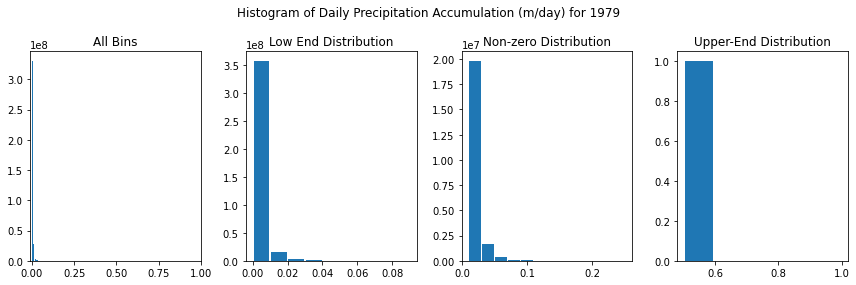

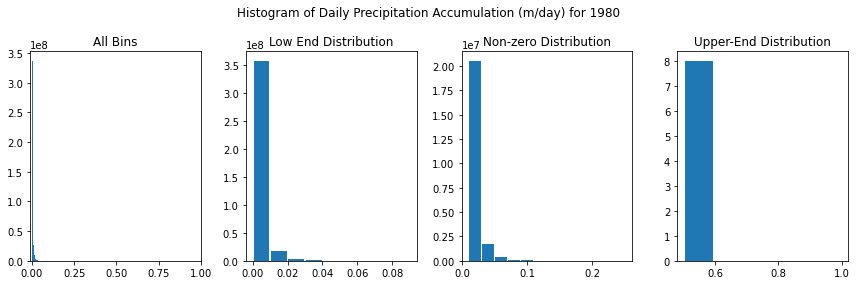

In [10]:
var_name = 'precip_total'
for year in years: 
    filename = '/gcs/impactlab-data/climate/source_data/ERA-5/day/precip_total/v1.1/precip_total_daily_{}-{}.nc'.format(year, year)
    ds = xr.open_mfdataset(filename)
    
    title = 'Histogram of Daily Precipitation Accumulation (m/day) for {}'.format(year)
    make_histogram_subplot(1,4, ds, var_name, all_bins, bin_titles, title)

Example of one sample year

1979


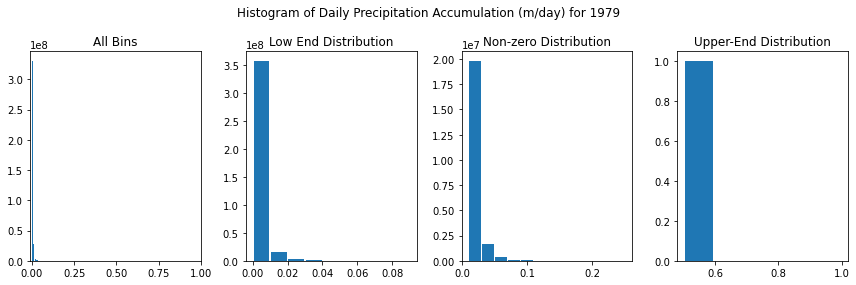

In [25]:
filename = '/gcs/impactlab-data/climate/source_data/ERA-5/day/precip_total/v1.1/precip_total_daily_1979-1979.nc'
ds = xr.open_mfdataset(filename)
    
title = 'Histogram of Daily Precipitation Accumulation (m/day) for 1979'
make_histogram_subplot(1,4, ds, var_name, all_bins, bin_titles, title)